In [1]:
# Cargamos la librerías
import geopandas as gpd
import pandas as pd
import numpy as np
from numpy import random
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import math
from scipy import stats

In [2]:
# CREAR GRID

def CrearGrid():
    # Limite del Grid
    xmin,ymin,xmax,ymax = (0,0,10000,10000)

    # Longitud de los lados
    length = 1000  ### 2000 metros -->5500/110000
    wide = 1000

    cols = list(np.arange(xmin,xmax,wide))
    rows = list(np.arange(ymin,ymax,length))

    rows.reverse()
    polygons = []
    X,Y=[],[]
    x_id,y_id=0,0
    for x in cols: 
        for y in rows:
            polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]))
            X.append(x_id)
            Y.append(y_id)
            y_id=y_id+1
        x_id=x_id+1
        y_id=0
        
    grid = gpd.GeoDataFrame({'geometry':polygons})

    # Agregar columnas de coordenadas
    grid["X"]=X
    grid["Y"]=Y
   
    return grid

# Numero de elementos en el grid
G=CrearGrid()
N=G.X.count()

# Definimos la población y vivienda total del sistema
PoblacionTotal=1000000
ViviendaTotal=500000

In [3]:
# DEFINIR POBLACIÓN BÁSICA (ALEATORIA)

def Pob_Inicial_Aleatoria(G):
    G["POBTOT"]=[np.random.randint(0,PoblacionTotal) for i in range(N)]
    
def Vivienda_Inicial_Aleatoria(G):
    G["VIV"]=[np.random.randint(0,ViviendaTotal) for i in range(N)]
        
def Poblacion_Inicial_normal(G, mu, sigma):
    # Creamos una funcion de distribución normal bivariada
    normal_bivariada = stats.multivariate_normal(mean=mu, cov=sigma)
    
    # Distribuimos la poblacion total a las cuadrículas con la probabilidad normal bivariada
    for i in range(0,N):
        G.loc[i,"POBTOT"]=normal_bivariada.pdf([G.loc[i,"X"],G.loc[i,"Y"]])*PoblacionTotal
        
def Vivienda_Inicial_normal(G, mu, sigma):
    # Creamos una funcion de distribución normal bivariada
    normal_bivariada = stats.multivariate_normal(mean=mu, cov=sigma)
    
    # Distribuimos la poblacion total a las cuadrículas con la probabilidad normal bivariada
    for i in range(0,N):
        G.loc[i,"VIV"]=normal_bivariada.pdf([G.loc[i,"X"],G.loc[i,"Y"]])*ViviendaTotal
    
def Ranking_Aleatorio(G):
    # Creamos la variable de Ranking por Unidad de manera aleatoria
    G["RANKING"]=[np.random.rand() for i in range(N)]
    
def Ranking_Normal(G, mu, sigma):
    # Creamos una funcion de distribución normal bivariada
    normal_bivariada = stats.multivariate_normal(mean=mu, cov=sigma)
    
    # Distribuimos los rankings las cuadrículas con la probabilidad normal bivariada
    for i in range(0,N):
        G.loc[i,"RANKING"]=normal_bivariada.pdf([G.loc[i,"X"],G.loc[i,"Y"]])
               
def Actualizar_Densidad(G):
    G["R_DENSIDAD"]=G["POBTOT"]/G["VIV"]

In [4]:
# Graficar 

def Graficar(G):
    fig, axes = plt.subplots(ncols=4, figsize=(20,10))  
    G.plot(column='POBTOT', legend=True, ax=axes[0])
    axes[0].set_title('Población')
    
    G.plot(column='VIV', legend=True, ax=axes[1])
    axes[1].set_title('Vivienda')
    
    G.plot(column='R_DENSIDAD', legend=True, ax=axes[2])
    axes[2].set_title('Densidad')
    
    G.plot(column='RANKING', legend=True, ax=axes[3], cmap='RdYlGn')
    axes[3].set_title('Ranking')
    plt.show()

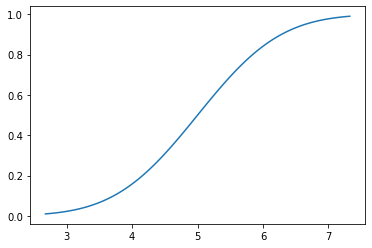

In [5]:
# Funciones en función de la densidad que definen la tasa de emigración
mu=5
sigma=1
f_normal = lambda x: stats.norm(mu, sigma).cdf(x)

# Graficando Función de Distribución Acumulada con Python
x_1 = np.linspace(stats.norm(mu, sigma).ppf(0.01),
                  stats.norm(mu, sigma).ppf(0.99), 100)
fda_normal = f_normal(x_1) # Función de Distribución Acumulada
plt.plot(x_1, fda_normal, label='FDA nomal')
plt.show()



## Modelo

**Dinámica poblacional:**

$P_i(t+1)=P_i(t)*(1+\alpha)+J_{j \rightarrow i}(t) - J_{i \rightarrow j}(t)$

> $P_i(t)$ es la poblacion de la celda $i$ en el tiempo $t$

> $J_{i \rightarrow j}$ población que migra de la celda $i$ a la celda $j$ en el tiempo t

> $\alpha$ tasa de crecimiento natural (poblacional) para la ciudad



**Crecimiento de vivienda:**

$C_i(t+1) = C_i(t)*(1+\beta)$

> $C_i(t)$ número de viviendas en la celda $i$ al tiempo $t$

> $beta$ tasa de crecimiento natural de vivienda


**Dinámica migratoria**

(Determina la cantidad de personas que emigran proporcional a un indice de saturación)

$ \sum_{j=1, \ j\neq i} J_{i \rightarrow j}(t)= s\left(\frac{P_i(t)}{C_i(t)}\right)*P_i(t)$

> $s(x)\subset [0,1] \ $ es el índice de saturación

(Distribuye las personas que migran en función de un ranking estático, la distancia y el índice de saturación)

$J_{i \rightarrow j}(t)= \frac{R_j*\left(1-s\left(\frac{P_j(t)}{C_j(t)}\right)\right)}{d(i,j)}*\sum_{j=1, \ j\neq i} J_{i \rightarrow j}(t)$

> $R_j\subset (0,1)$ es el ranking de la celda $j$

> $d(i,j)$ es la distancia euclidiana entre la celda $i$ y la $j$

(En realidad el primer término se normaliza respecto a la suma total)

In [6]:
def Actualizacion(G, iteraciones, alpha, beta):     
    G_Nueva=G
             
    # Agregamos las coordenadas del centroide de cada polígono
    G_centroides=G.geometry.centroid
    # Creamos la matriz de distancia entre los centroides
    M_Distancia=[]
    for i in G_centroides:
        M_Distancia.append([i.distance(j) for j in G_centroides])
    M_Distancia=np.array(M_Distancia)
    
    # Modelación de la dinámica poblacional
    for t in range(0,iteraciones):
        Natural_Pob=G_Nueva["POBTOT"]*alpha   # Calculamos el crecimiento natural de la poblacion
        Natural_VIV=G_Nueva["VIV"]*beta       # Calculamos el crecimiento natural de la vivienda
        
        # A partir de la saturación definimos una tasa de emigración y el total de la población que sale de cada AGEB
        Tasa_Emigracion=[f_normal(G_Nueva.loc[i,"R_DENSIDAD"]) for i in range(0,N)]
        Total_Emigracion=Tasa_Emigracion*G_Nueva.POBTOT
        Indice_Saturacion= 1-np.array(Tasa_Emigracion)
                
        # Distribuimos la emigración a los diferentes AGEB a partir del ranking y la distancia
        Matriz_Inmigracion=[]
        for i in range(0,N):
            # Ajustamos el ranking en términos de la distancia y normalizamos para tener una probabilidad
            Ranking_Actualizado = [j if j!=np.inf else 0 for j in G_Nueva["RANKING"]/M_Distancia[i]]
            Ranking_Actualizado = Ranking_Actualizado
            Ranking_Actualizado = Ranking_Actualizado/np.array(Ranking_Actualizado).sum()
            Ranking_Actualizado = Ranking_Actualizado*Indice_Saturacion
            Inmigracion = Ranking_Actualizado*Total_Emigracion[i]
            Matriz_Inmigracion.append(Inmigracion)  
            
        #Calculamos la población total que inmigra a un AGEB
        Matriz_Inmigracion=np.array(Matriz_Inmigracion)
        Inmigracion_Recibida=[Matriz_Inmigracion[:, j].sum() for j in range(0,N)]
        
        # Actualizar la población, vivienda y densidad
        G_Nueva["POBTOT"]=G_Nueva["POBTOT"]+Natural_Pob-Total_Emigracion+Inmigracion_Recibida
        G_Nueva["VIV"]=G_Nueva["VIV"]+Natural_VIV
        G_Nueva["R_DENSIDAD"]=G_Nueva["POBTOT"]/G_Nueva["VIV"]

    return G_Nueva

# A)

### Poblacion y vivienda normal bivariada mismo centro y matriz de correlación

### Ranking aleatorio

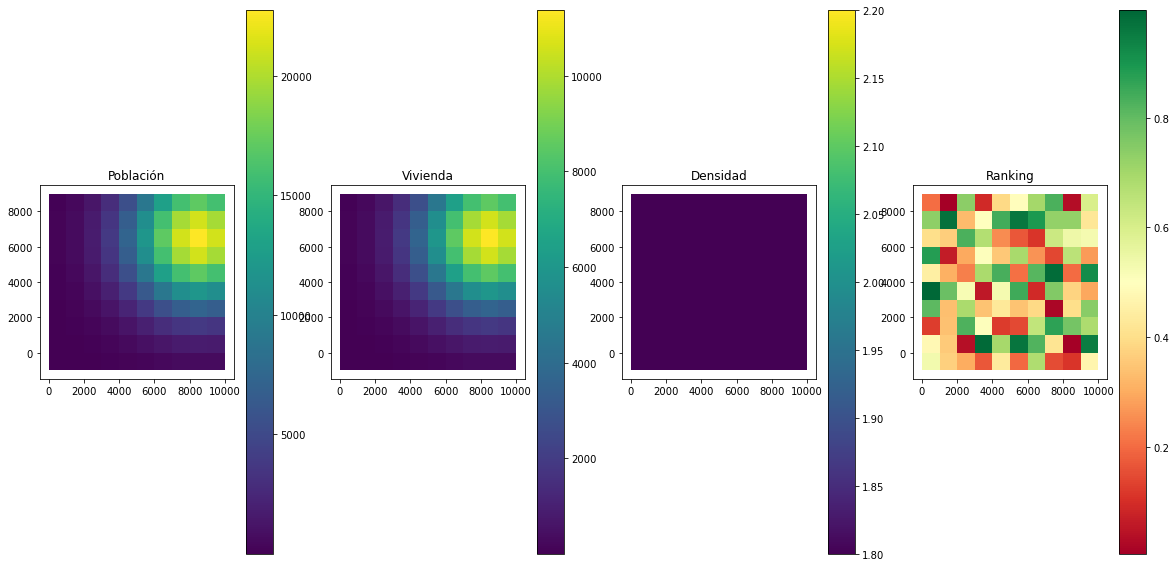

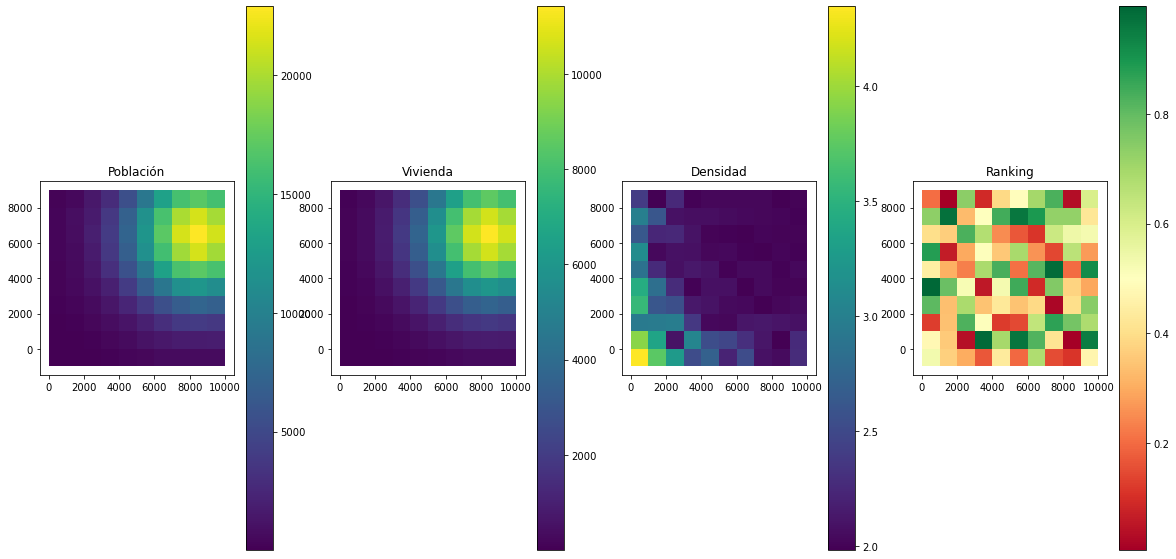

In [7]:
G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Aleatorio(G)
Graficar(G)

K=Actualizacion(G,20, 0.001,0.0002)
Graficar(K)

Se observa una difusión aleatoria de la población, pero una aumento (con ruido) de la densidad de la periferia.

# B)

### Poblacion y vivienda normal bivariada mismo centro pero diferente matriz de correlación

### Ranking aleatorio

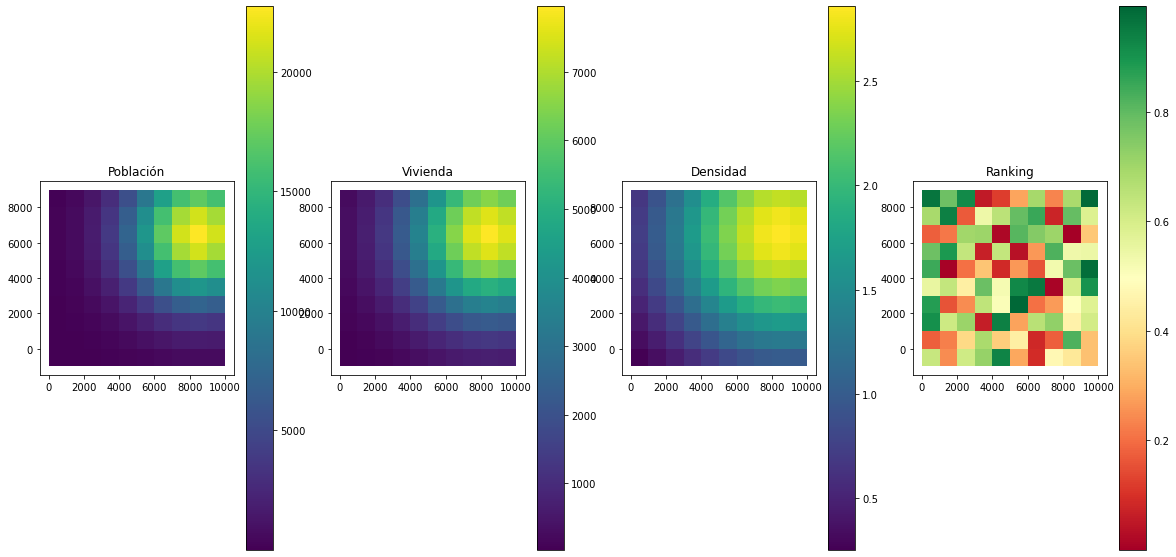

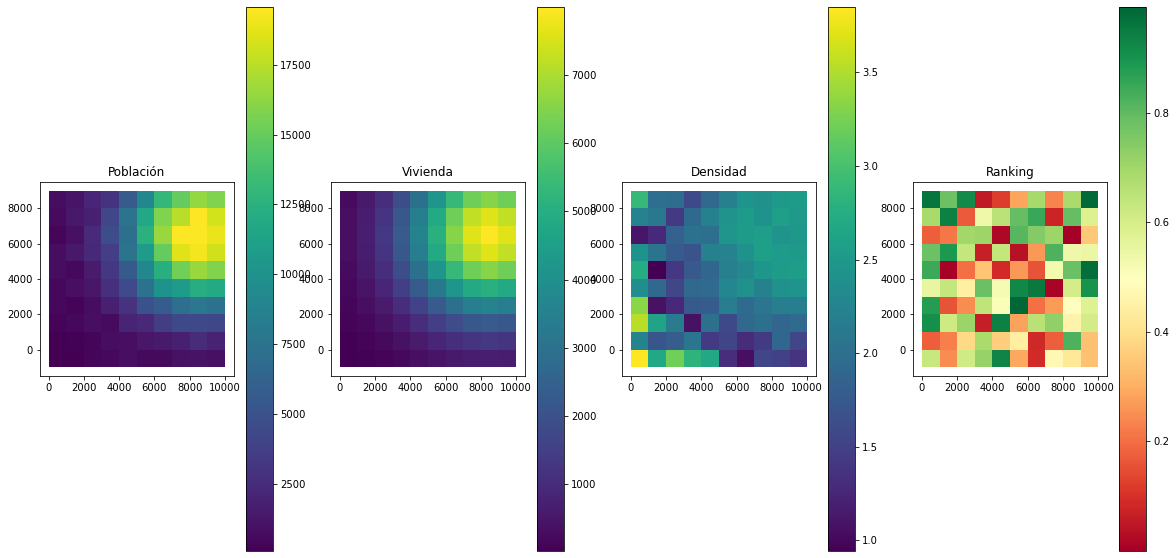

In [8]:

G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_normal(G, [8,2], [[10,0],[0,10]])
Actualizar_Densidad(G)
Ranking_Aleatorio(G)
Graficar(G)

K=Actualizacion(G,20, 0.001,0.0002)
Graficar(K)

Al aumentar el "radio" de la distribución de vivienda aumenta más la densidad de la perfieria que en el primer caso y la difusión de la población.

# C)

### Poblacion y vivienda normal bivariada centros diferentes y misma matrizde correlación

### Ranking aleatorio

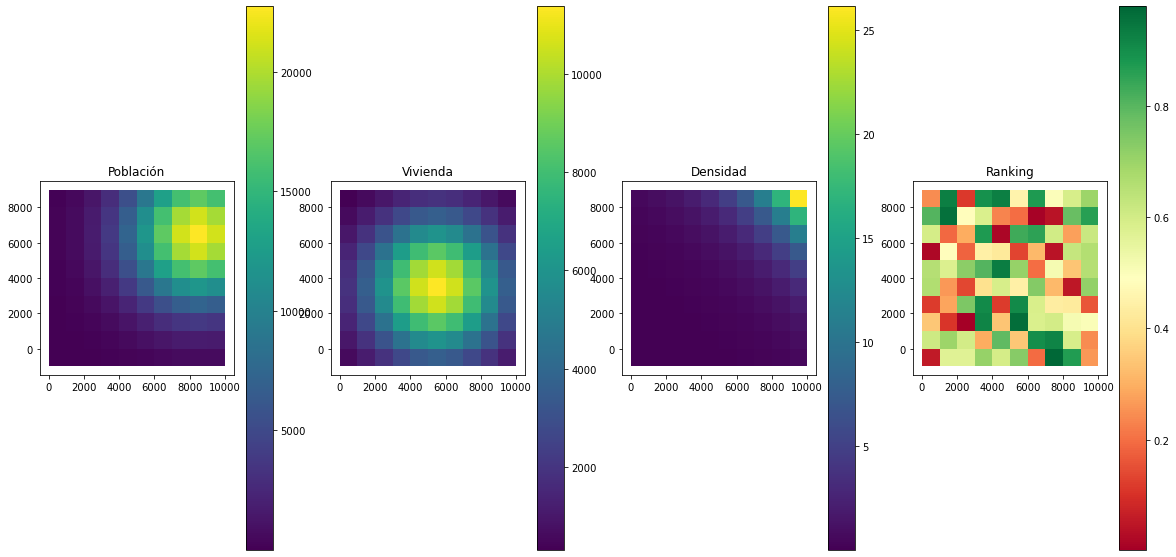

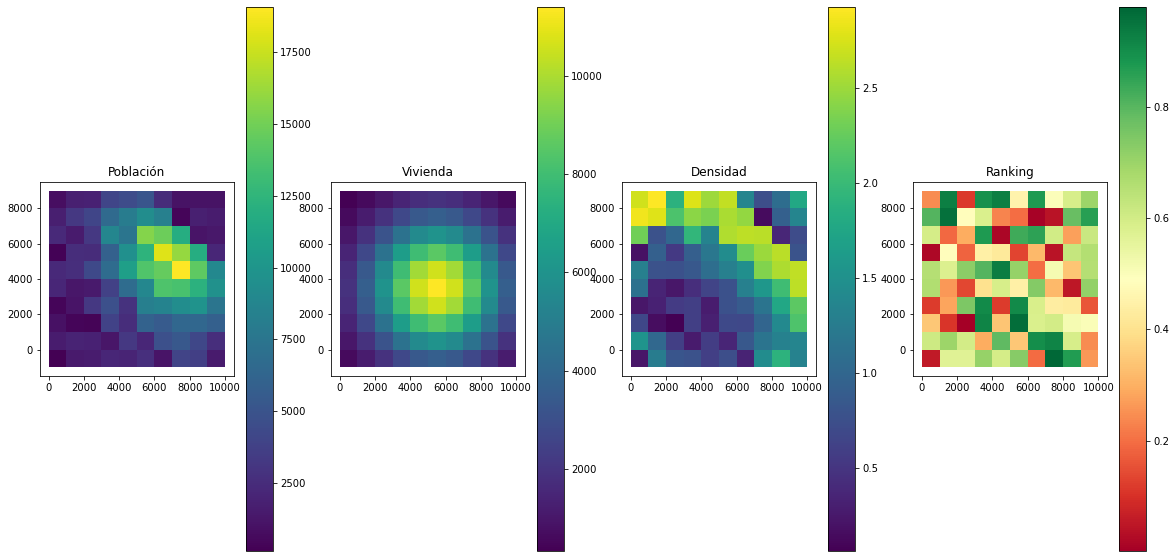

In [9]:

G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_normal(G, [5,5], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Aleatorio(G)
Graficar(G)

K=Actualizacion(G,20, 0.001,0.0002)
Graficar(K)

Se observa que la densidad aumenta en la periferia, y ligeramente que la distribución de población se agrupa donde hay más vivienda aunque conmucho ruido (Aqui dejamos mil iteraciones para observar eso)

# D)

### Poblacion y vivienda normal bivariada mismo centro
### Ranking normal bivariado centro diferente

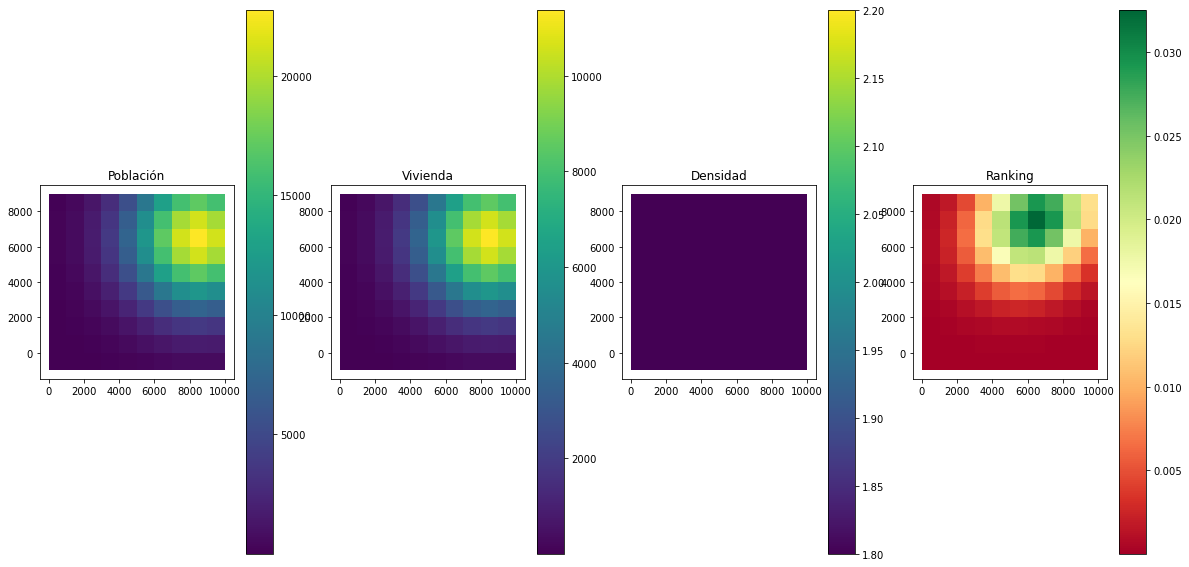

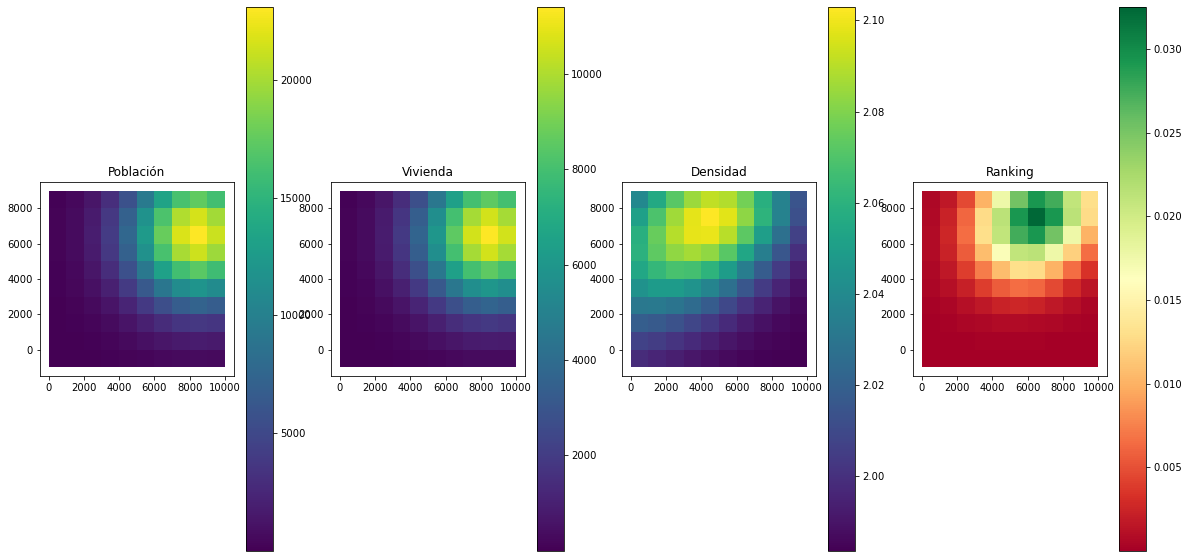

In [10]:
G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Normal(G, [6,1], [[5,-1],[-1,5]])
Graficar(G)

K=Actualizacion(G,20, 0.001,0.0001)
Graficar(K)

# E)
### Poblacion y vivienda normal bivariada diferente centro
### Ranking normal bivariado centro diferente

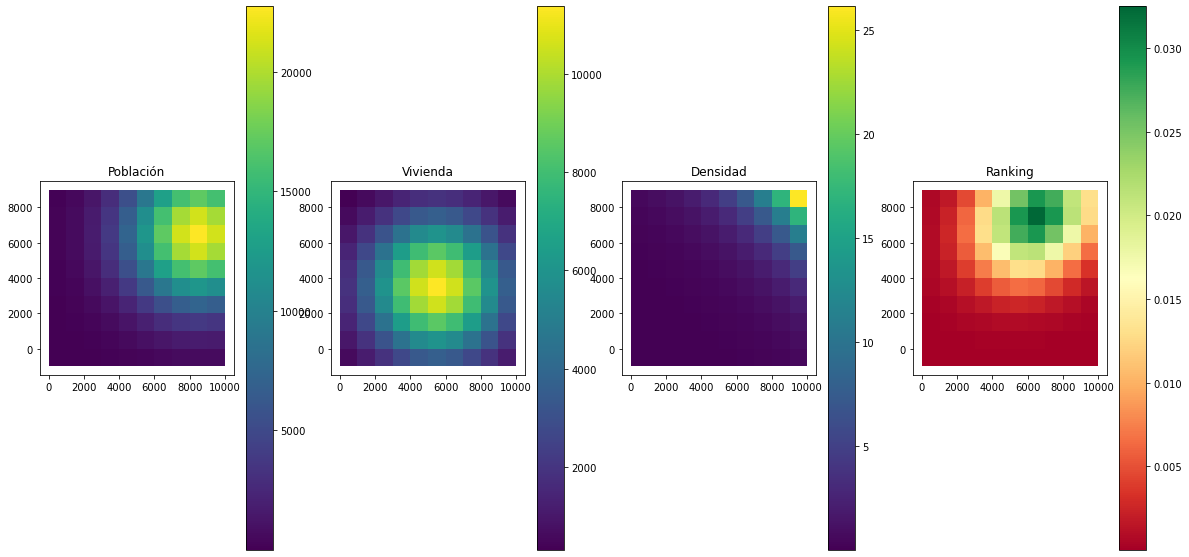

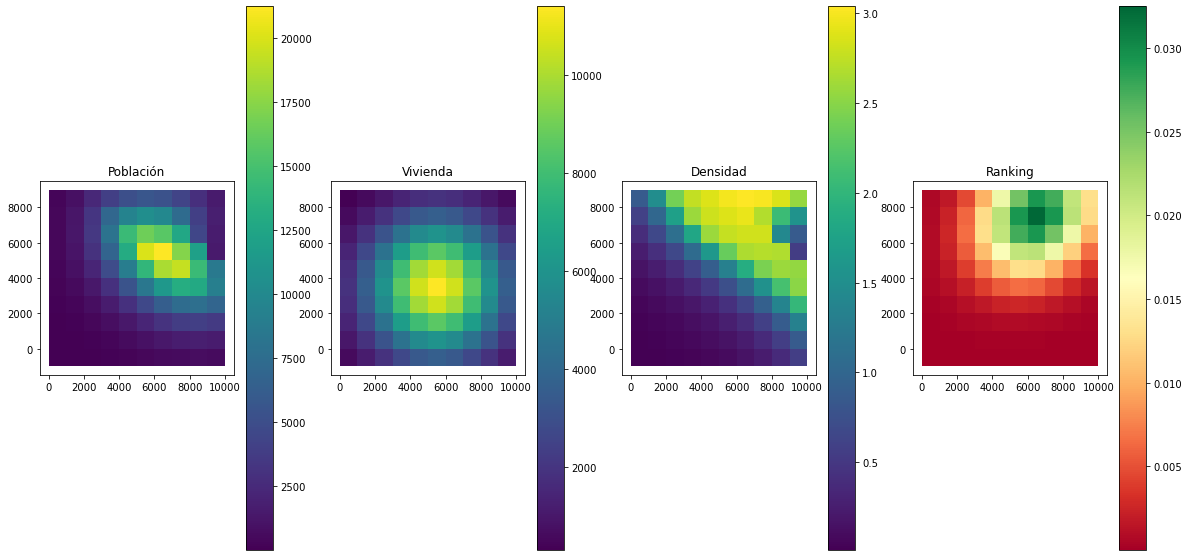

In [11]:
G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_normal(G, [5,5], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Normal(G, [6,1], [[5,-1],[-1,5]])
Graficar(G)

K=Actualizacion(G,20, 0.001,0.0001)
Graficar(K)

La densidad se concentra enla periferia que esta cercana al centro del ranking

# F)
### Poblacion y ranking normal bivariada con el mismo centro
### Vivienda normal bivariado centro diferente


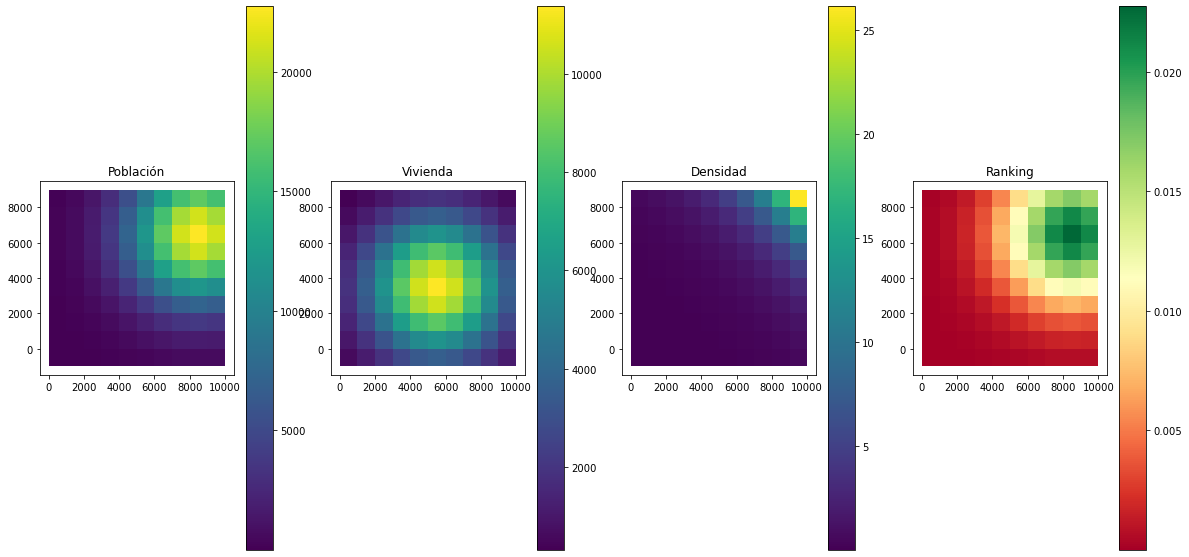

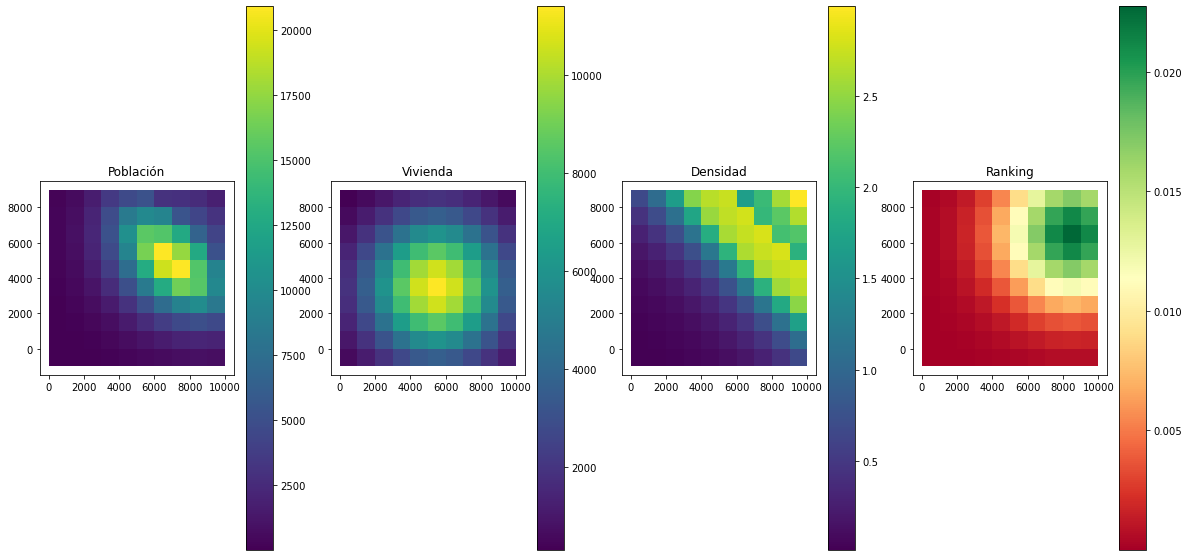

In [12]:
G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_normal(G, [5,5], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Normal(G, [8,2], [[7,0],[0,7]])
Graficar(G)

K=Actualizacion(G,20, 0.001,0.0001)
Graficar(K)

### Poblacion  aleatoria
### Vivienda normal bivariad
### Ranking normal bivariado  (otro centro)

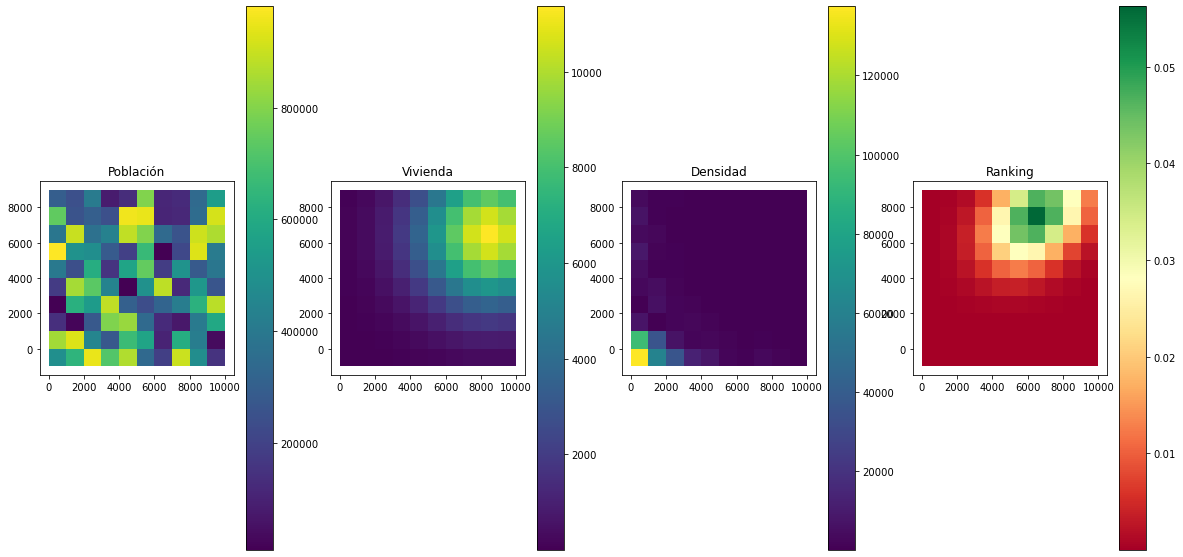

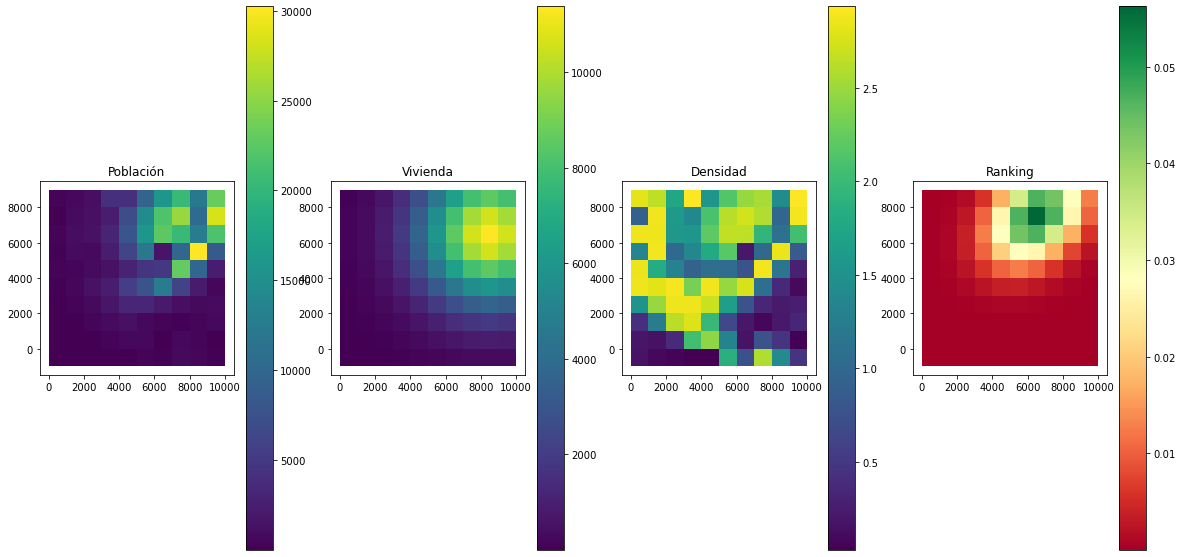

In [13]:
G = CrearGrid()
Pob_Inicial_Aleatoria(G)
Vivienda_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Normal(G, [6,1], [[3,1],[-1,3]])
Graficar(G)

K=Actualizacion(G,10, 0.001,0.0001)
Graficar(K)

### Poblacion y ranking aleatoria
### Vivienda normal bivariad

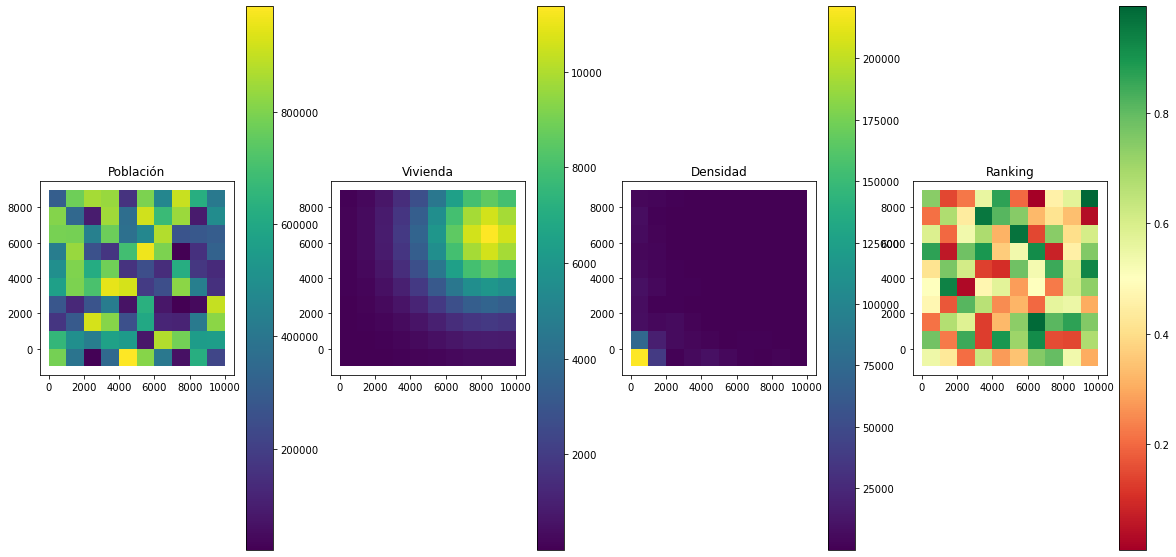

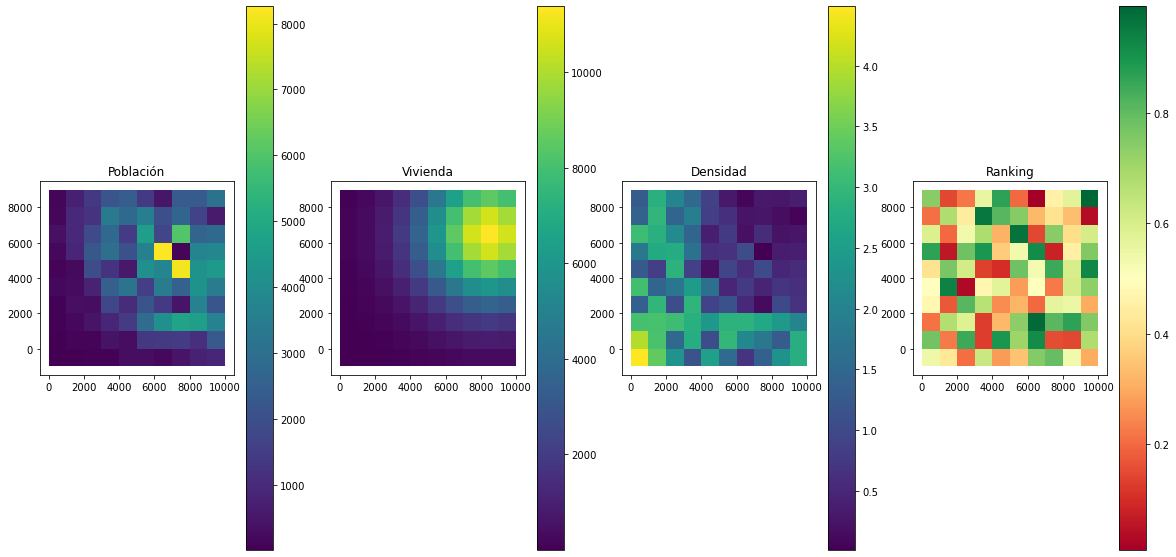

In [14]:
G = CrearGrid()
Pob_Inicial_Aleatoria(G)
Vivienda_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Actualizar_Densidad(G)
Ranking_Aleatorio(G)
Graficar(G)

K=Actualizacion(G,10, 0.001,0.0001)
Graficar(K)

### Población y ranking Bivariada
### Vivienda  Aleatoria

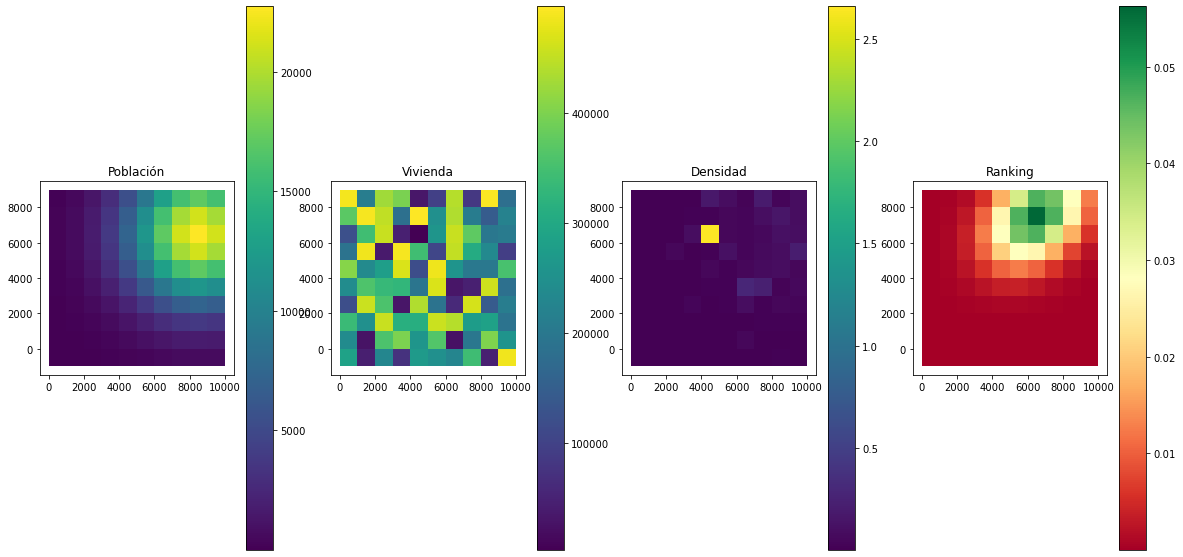

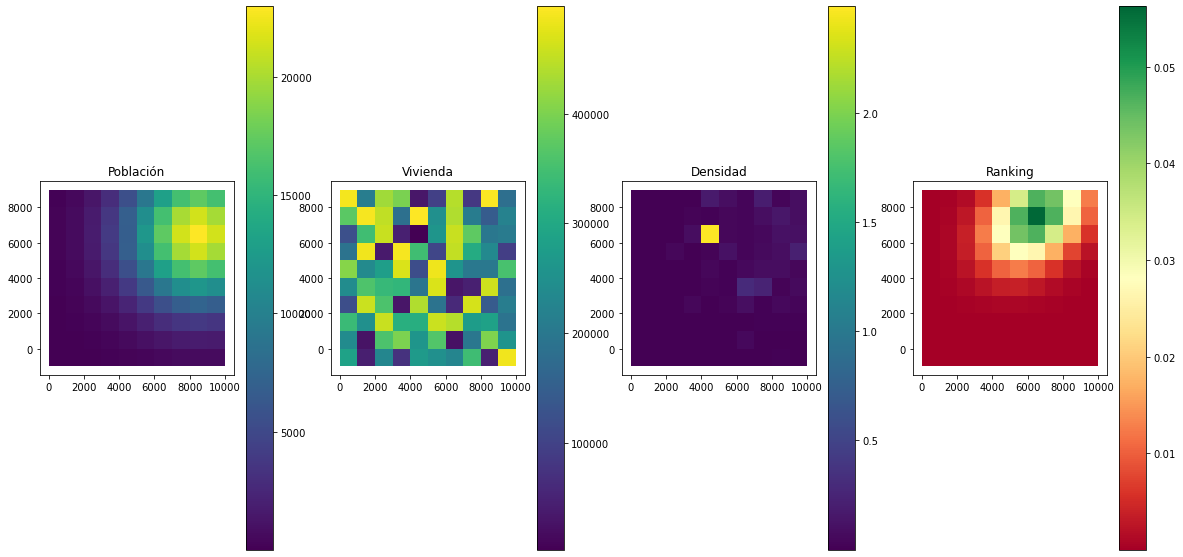

In [15]:
G = CrearGrid()
Poblacion_Inicial_normal(G, [8,2], [[7,0],[0,7]])
Vivienda_Inicial_Aleatoria(G)
Actualizar_Densidad(G)
Ranking_Normal(G, [6,1], [[3,1],[-1,3]])
Graficar(G)

K=Actualizacion(G,10, 0.001,0.0001)
Graficar(K)